In [1]:
import sys
import os
import numpy as np
import mat73
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
# from scipy.signal import convolve2d
from scipy.interpolate import RegularGridInterpolator
from torch.utils.data import random_split
import pickle
import cartopy.crs as ccrs
from datetime import datetime, timedelta
# from matplotlib.dates import date2num, num2date
# from sklearn.cluster import MiniBatchKMeans
sys.path.append("/home/jmiranda/SubsurfaceFields/GEM_SubsurfaceFields/eoas_pyutils/")
from io_utils.coaps_io_data import get_aviso_by_date, get_sst_by_date, get_sss_by_date

def datenum_to_datetime(matlab_datenum):
    # MATLAB's datenum (1) is equivalent to January 1, year 0000, but Python's datetime minimal year is 1
    # There are 366 days for year 0 in MATLAB (it's a leap year in proleptic ISO calendar)
    days_from_year_0_to_year_1 = 366
    python_datetime = datetime.fromordinal(int(matlab_datenum) - days_from_year_0_to_year_1) + timedelta(days=matlab_datenum % 1)
    return python_datetime

class TemperatureSalinityDataset(torch.utils.data.Dataset):
    """
    Custom dataset for temperature and salinity profiles.
    
    Attributes:
    - TEMP: Temperature profiles matrix.
    - SAL: Salinity profiles matrix.
    - SSH: Sea Surface Height vector.
    - pca_temp: PCA model for temperature profiles.
    - pca_sal: PCA model for salinity profiles.
    - temp_pcs: Transformed temperature profiles using PCA.
    - sal_pcs: Transformed salinity profiles using PCA.
    """
    def __init__(self, path, n_components=15, input_params=None, max_depth = 2000, pred_temp = True, pred_sal = True):
        """
        Args:
        - path (str): File path to the dataset.
        - n_components (int): Number of PCA components to retain.
        """
        self.aviso_folder = "/unity/f1/ozavala/DATA/GOFFISH/AVISO/GoM/"
        self.sst_folder = "/unity/f1/ozavala/DATA/GOFFISH/SST/OISST"
        
        self.max_depth = max_depth
        self.pred_temp = pred_temp
        self.pred_sal = pred_sal
        data = mat73.loadmat(path)
        self.TIME = [datenum_to_datetime(datenum) for datenum in data['TIME']]
        # self.TIME = data['TIME']
        self.LAT = data['LAT']
        self.LON = data['LON']
        self.min_lat = 17.0
        self.max_lat = 29.0
        self.min_lon = -91.0
        self.max_lon = -78.0
        
        # Define which parameters to include
        if input_params is None:
            input_params = {
                "timecos": False,
                "timesin": False,
                "latcos": False,
                "latsin": False,
                "loncos": False,
                "lonsin": False,
                "sst": True,  # First value of temperature
                "sss": True,
                "ssh": True
            }

        self.input_params = input_params
        
        # New method to load SST and SSH data
        self.SST, self.SSH = self._load_sst_ssh_data()
        
        valid_mask = self._get_valid_mask(data)
        self.TEMP, self.SAL, self.SSH, self.SST, self.TIME, self.LAT, self.LON = self._filter_and_fill_data(data, valid_mask)
        
        # Applying PCA
        self.temp_pcs, self.pca_temp = self._apply_pca(self.TEMP, n_components)
        self.sal_pcs, self.pca_sal = self._apply_pca(self.SAL, n_components)

    def _load_sst_ssh_data(self):
        """
        New method to load SST and SSH data
        """
        unique_dates = sorted(list(set(self.TIME)))
        sst_data = np.nan * np.ones(len(self.TIME))
        aviso_data = np.nan * np.ones(len(self.TIME))
        
        # # Convert serialized date numbers to date objects
        # base_date = datetime(1, 1, 1)

        # for idx, serialized_date in enumerate(unique_dates):
        for idx, c_date in enumerate(unique_dates):
            # c_date = base_date + timedelta(days=float(serialized_date))
            date_idx = np.array([date_obj == c_date for date_obj in self.TIME])  # Ensure both sides of the comparison are datetime objects
            coordinates = np.array([self.LAT[date_idx], self.LON[date_idx]]).T
            
            try:
                aviso_date, aviso_lats, aviso_lons = get_aviso_by_date(self.aviso_folder, c_date, bbox=(self.min_lat, self.max_lat, self.min_lon, self.max_lon))
                interpolator_ssh = RegularGridInterpolator((aviso_lats, aviso_lons), aviso_date.adt.values, bounds_error=False, fill_value=None)
                aviso_data[date_idx] = interpolator_ssh(coordinates)
            except Exception as e:
                print("AVISO not found for date ", c_date, "Error: ", str(e))
                continue

            try:
                sst_date, sst_lats, sst_lons = get_sst_by_date(self.sst_folder, c_date, bbox=(self.min_lat, self.max_lat, self.min_lon, self.max_lon))
                interpolator_sst = RegularGridInterpolator((sst_lats, sst_lons), sst_date.analysed_sst.values[0], bounds_error=False, fill_value=None)
                sst_data[date_idx] = interpolator_sst(coordinates)
            except Exception as e:
                print("SST not found for date ", c_date, "Error: ", str(e))
                continue

    # Check if data was actually filled
            if np.isnan(aviso_data[date_idx]).all():
                print(f"No AVISO data for date {c_date}")
            if np.isnan(sst_data[date_idx]).all():
                print(f"No SST data for date {c_date}")

        return sst_data, aviso_data

    def __getitem__(self, idx):
        """
        Args:
        - idx (int): Index of the profile.

        Returns:
        - tuple: input values and concatenated PCA components for temperature and salinity.
        """
        
        inputs = []
        
        if self.input_params["timecos"]:
            inputs.append(np.cos(2*np.pi*(self.TIME[idx]%365)/365)) 
            
        if self.input_params["timesin"]:
            inputs.append(np.sin(2*np.pi*(self.TIME[idx]%365)/365))  
        
        if self.input_params["latcos"]:
            inputs.append(np.cos(2*np.pi*(self.LAT[idx]/180)))

        if self.input_params["latsin"]:
            inputs.append(np.sin(2*np.pi*(self.LAT[idx]/180)))  

        if self.input_params["loncos"]:
            inputs.append(np.cos(2*np.pi*(self.LON[idx]/360)))  
            
        if self.input_params["loncos"]:
            inputs.append(np.sin(2*np.pi*(self.LON[idx]/360)))
                
        if self.input_params["sss"]:
            inputs.append(self.SAL[0, idx])

        if self.input_params["sst"]:
            inputs.append(self.TEMP[0, idx])  # First value of temperature profile
        
        if self.input_params["ssh"]:
            inputs.append(self.SSH[idx])
            
        inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
        # profiles = torch.tensor(np.hstack([self.sal_pcs[:, idx]]), dtype=torch.float32)
        profiles = torch.tensor(np.hstack([self.temp_pcs[:, idx], self.sal_pcs[:, idx]]), dtype=torch.float32)
        
        return inputs_tensor, profiles
    
    def _get_valid_mask(self, data):
        """Internal method to get mask of valid profiles based on missing values."""
        temp_mask = np.sum(np.isnan(data['TEMP']), axis=0) <= 5
        sal_mask = np.sum(np.isnan(data['SAL']), axis=0) <= 5
        # sanity check: check sizes
        # print(len(temp_mask), len(sal_mask), len(self.SSH), len(self.SST))
        ssh_mask = ~np.isnan(self.SSH)
        sst_mask = ~np.isnan(self.SST)
        print(len(temp_mask), len(sal_mask), len(ssh_mask), len(sst_mask))
        combined_mask = np.logical_and(temp_mask, sal_mask)
        print(f"Filtered dataset (sal/temp) contains {np.sum(combined_mask)} profiles.")
        combined_mask = np.logical_and(combined_mask, sst_mask)
        print(f"Filtered dataset (sal/temp/sst) contains {np.sum(combined_mask)} profiles.")
        combined_mask = np.logical_and(combined_mask, ssh_mask)
        print(f"Filtered dataset (sal/temp/ssh/sst) contains {np.sum(combined_mask)} profiles.")
        
        return combined_mask
    
    def _filter_and_fill_data(self, data, valid_mask):
        """Internal method to filter data using the mask and fill missing values."""
        TEMP = data['TEMP'][:self.max_depth+1, valid_mask]
        SAL = data['SAL'][:self.max_depth+1, valid_mask]
        SSH = self.SSH[valid_mask]
        SST = self.SST[valid_mask]
        TIME = data['TIME'][valid_mask]
        LAT = data['LAT'][valid_mask]
        LON = data['LON'][valid_mask]
        
        # Fill missing values using interpolation
        for i in range(TEMP.shape[1]):
            valid_temp_idx = np.where(~np.isnan(TEMP[:, i]))[0]
            TEMP[:, i] = np.interp(range(TEMP.shape[0]), valid_temp_idx, TEMP[valid_temp_idx, i])
            valid_sal_idx = np.where(~np.isnan(SAL[:, i]))[0]
            SAL[:, i] = np.interp(range(SAL.shape[0]), valid_sal_idx, SAL[valid_sal_idx, i])
        
        # # Define the moving average filter (e.g., for a window size of 5)
        # window_size = 5
        # passes = 1
        # filter_weights = np.ones((window_size, 1)) / window_size
        
        # for i in range(passes):
        #     # Apply the moving average filter to the entire matrix
        #     TEMP = convolve2d(TEMP, filter_weights, boundary='symm', mode='same')
        #     SAL = convolve2d(SAL, filter_weights, boundary='symm', mode='same') 
        
        return TEMP, SAL, SSH, SST, TIME, LAT, LON

    def _apply_pca(self, data, n_components):
        """Internal method to apply PCA transformation to the data."""
        pca = PCA(n_components=n_components)
        pcs = pca.fit_transform(data.T).T
        return pcs, pca
    
    def __len__(self):
        """Returns number of profiles in the dataset."""
        return self.TEMP.shape[1]
    
    def inverse_transform(self, pcs):
        """
        Inverse the PCA transformation.

        Args:
        - pcs (numpy.ndarray): Concatenated PCA components for temperature and salinity.

        Returns:
        - tuple: Inversed temperature and salinity profiles.
        """
        temp_profiles = self.pca_temp.inverse_transform(pcs[:, :n_components]).T
        sal_profiles = self.pca_sal.inverse_transform(pcs[:, n_components:]).T
        return temp_profiles, sal_profiles
    
    def get_profiles(self, indices, pca_approx=False):
        """
        Returns temperature and salinity profiles for the given indices.

        Args:
        - indices (list or numpy.ndarray): List of indices for which profiles are needed.
        - pca_approx (bool): Flag to return PCA approximated profiles if True, 
                             or original profiles if False.

        Returns:
        - numpy.ndarray: concatenated temperature and salinity profiles in the required format for visualization.
        """
        if pca_approx:
            # Concatenate temp and sal PCA components for the given indices
            concatenated_pcs = np.hstack([self.temp_pcs[:, indices].T, self.sal_pcs[:, indices].T])
            # Obtain PCA approximations using the concatenated components
            temp_profiles, sal_profiles = self.inverse_transform(concatenated_pcs)
        else:
            temp_profiles = self.TEMP[:, indices]
            sal_profiles = self.SAL[:, indices]

        # Stack along the third dimension
        profiles_array = np.stack([temp_profiles, sal_profiles], axis=1)

        return profiles_array
    
    def get_gem_profiles(self, indices, filename='/home/jmiranda/SubsurfaceFields/GEM_SubsurfaceFields/GEM_polyfits.pkl'):
        # Load GEM polyfits from file
        with open(filename, 'rb') as f:
            gem_polyfits = pickle.load(f)
            
        # Interpolate the temperature and salinity data onto the new grid
        temp_GEM = np.empty((len(indices), self.max_depth+1))
        sal_GEM = np.empty((len(indices), self.max_depth+1))

        # For each pressure level
        for i in range(len(gem_polyfits['TEMP'])):
            # Evaluate the fitted polynomial at the given SSH values
            temp_GEM[:, i] = gem_polyfits['TEMP'][i](self.SSH[indices])
            sal_GEM[:, i] = gem_polyfits['SAL'][i](self.SSH[indices])
        
        # Interpolate missing values in temp_GEM and sal_GEM
        for array in [temp_GEM, sal_GEM]:
            for row in range(array.shape[0]):
                valid_mask = ~np.isnan(array[row])
                if not valid_mask.any():  # skip rows with only NaNs
                    continue

                array[row] = np.interp(np.arange(array.shape[1]), np.where(valid_mask)[0], array[row, valid_mask])
        
                # If NaNs at the start, fill with the first non-NaN value
                first_valid_idx = valid_mask.argmax()
                array[row, :first_valid_idx] = array[row, first_valid_idx]
                
                # If NaNs at the end, fill with the last non-NaN value
                last_valid_idx = len(array[row]) - valid_mask[::-1].argmax() - 1
                array[row, last_valid_idx+1:] = array[row, last_valid_idx]
        
        return temp_GEM, sal_GEM
    
    def get_inputs(self, idx):
        sst_inputs = self.TEMP[0, idx]
        ssh_inputs = self.SSH[idx]
        return sst_inputs, ssh_inputs
    
    def get_lat_lon_date(self, idx):
        lat = self.LAT[idx]
        lon = self.LON[idx]
        date = self.TIME[idx]
        return lat, lon, date

class PredictionModel(nn.Module):
    """
    Neural Network model for predicting temperature and salinity profiles based on sea surface height (SSH).

    Attributes:
    - model (nn.Sequential): Sequential model containing layers defined by `layers_config`.

    Parameters:
    - input_dim (int): Dimension of the input feature(s). Default is 1 (for SSH).
    - layers_config (list of int): List where each element represents the number of neurons in 
                                   a respective layer. Default is [512, 256].
    - output_dim (int): Dimension of the output. Default is 30 (15 components for TEMP and 15 for SAL).

    Methods:
    - forward(x: torch.Tensor) -> torch.Tensor: Forward pass through the model.
    """

    def __init__(self, input_dim=1, layers_config=[512, 256], output_dim=30, dropout_prob = 0.5):
        super(PredictionModel, self).__init__()
        
        # Construct layers based on the given configuration
        layers = []
        prev_dim = input_dim
        for neurons in layers_config:
            layers.append(nn.Linear(prev_dim, neurons))
            # layers.append(nn.ReLU())
            layers.append(nn.Tanh())
            if dropout_prob > 0:
                layers.append(nn.Dropout(dropout_prob)) # added dropout
            prev_dim = neurons
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.model = nn.Sequential(*layers)      
    
    def forward(self, x):
        """
        Forward pass through the model.

        Parameters:
        - x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
        - torch.Tensor: Model's predictions of shape (batch_size, output_dim).
        """
        return self.model(x)
    
def split_dataset(dataset, train_size, val_size, test_size, batch_size=32, use_batches=True):
    """
    Splits the dataset into training, validation, and test sets.
    
    Parameters:
    - dataset: The entire dataset to be split.
    - train_size, val_size, test_size: Proportions for splitting. They should sum to 1.
    
    Returns:
    - train_dataset, val_dataset, test_dataset: Split datasets.
    """
    total_size = len(dataset)
    train_len = int(total_size * train_size)
    val_len = int(total_size * val_size)
    test_len = total_size - train_len - val_len

    return random_split(dataset, [train_len, val_len, test_len])

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=100, patience=10):
    """
    Train the model with early stopping and CUDA support.

    Parameters:
    - model: the PyTorch model.
    - train_loader: the DataLoader for training data.
    - val_loader: the DataLoader for validation data.
    - criterion: the loss function.
    - optimizer: the optimizer.
    - device: device to which data and model should be moved before training.
    - epochs: number of total epochs to train.
    - patience: number of epochs to wait for improvement before stopping.

    Returns:
    - model: trained model.
    """
    model.to(device)
    best_val_loss = float('inf')
    best_weights = None  # To store best model weights
    no_improve_count = 0

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        
        # Validation loss
        avg_val_loss = evaluate_model(model, val_loader, criterion, device)
        print(f"Epoch [{epoch + 1}/{epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_weights = model.state_dict()  # Save the model weights
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print(f"Early stopping at Epoch {epoch + 1}")
                break

    model.load_state_dict(best_weights)  # Load the best model weights
    return model

def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluate the model on the provided data with CUDA support.

    Parameters:
    - model: the PyTorch model.
    - dataloader: the DataLoader for evaluation data.
    - criterion: the loss function.
    - device: device to which data and model should be moved before evaluation.

    Returns:
    - avg_loss: average loss over the dataset.
    """
    model.to(device)
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    return avg_loss

def get_predictions(model, dataloader, device):
    """
    Get model's predictions on the provided data with CUDA support.

    Parameters:
    - model: the PyTorch model.
    - dataloader: the DataLoader for the data.
    - device: device to which data and model should be moved before getting predictions.

    Returns:
    - predictions: model's predictions.
    """
    model.to(device)
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs[0].to(device)  # Getting only the input features, ignoring labels
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())

    return np.array(predictions)

def get_inputs(dataloader, device):
    """
    Get inputs from the provided dataloader with CUDA support.

    Parameters:
    - dataloader: the DataLoader for the data.
    - device: device to which data should be moved.

    Returns:
    - all_inputs: list of inputs from the dataloader.
    """
    all_inputs = []

    for inputs in dataloader:
        inputs = inputs[0].to(device)  # Getting only the input features, ignoring labels
        all_inputs.extend(inputs.cpu().numpy())

    return np.array(all_inputs)

def predict_with_numpy(model, numpy_input, device="cuda"):
    # Convert numpy array to tensor
    tensor_input = torch.tensor(numpy_input, dtype=torch.float32)
    
    # Check if CUDA is available and move tensor to the appropriate device
    if device == "cuda" and torch.cuda.is_available():
        tensor_input = tensor_input.cuda()
        model = model.cuda()
    
    # Make sure the model is in evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        predictions = model(tensor_input)
    
    # Convert predictions back to numpy (if on GPU, move to CPU first)
    numpy_predictions = predictions.cpu().numpy()
    
    return numpy_predictions

def inverse_transform(pcs, pca_temp, pca_sal, n_components):
    """
    Inverse the PCA transformation.

    Args:
    - pcs (numpy.ndarray): Concatenated PCA components for temperature and salinity.
    - pca_temp, pca_sal: PCA models for temperature and salinity respectively.
    - n_components (int): Number of PCA components.

    Returns:
    - tuple: Inversed temperature and salinity profiles.
    """
    temp_profiles = pca_temp.inverse_transform(pcs[:, :n_components]).T
    sal_profiles = pca_sal.inverse_transform(pcs[:, n_components:]).T
    return temp_profiles, sal_profiles

## Custom Loss

class WeightedMSELoss(nn.Module):
    def __init__(self, weights, device):
        super(WeightedMSELoss, self).__init__()
        self.weights = torch.tensor(weights, dtype=torch.float32).to(device)

    def forward(self, input, target):
        squared_diff = (input - target) ** 2
        weighted_squared_diff = self.weights * squared_diff
        loss = weighted_squared_diff.mean()
        return loss

def genWeightedMSELoss(n_components, device, offset = 3):
    # Generate descending weights for one set (either TEMP or SAL)
    single_set_weights = np.arange(n_components + offset, offset, -1)
    # Repeat for both TEMP and SAL
    weights = torch.tensor(np.concatenate([single_set_weights, single_set_weights]))
    return WeightedMSELoss(weights, device)
   
def visualize_combined_results(true_values, gem_temp, gem_sal, predicted_values, sst_values, ssh_values, max_depth=2000, num_samples=5):
    # TODO: add date to plot
    """
    Visualize the true vs. predicted vs. GEM approximated values for a sample of profiles and their differences.

    Parameters:
    - true_values: ground truth temperature and salinity profiles.
    - gem_temp: GEM approximated temperature profiles.
    - gem_sal: GEM approximated salinity profiles.
    - predicted_values: model's predicted temperature and salinity profiles.
    - sst_values: Sea Surface Temperature values for each profile.
    - ssh_values: Sea Surface Height (adt) values for each profile.
    - num_samples: number of random profiles to visualize.

    Returns:
    - None (plots the results).
    """
    n_depths = max_depth + 1
    depth_levels = np.arange(n_depths)
    population_size = true_values.shape[2]

    if num_samples == population_size:
        indices = np.arange(num_samples)
    else:
        indices = np.random.choice(int(population_size), num_samples, replace=False)

    for idx in indices:
        fig, axs = plt.subplots(2, 2, figsize=(12, 12))

        # First row: Actual Profiles
        # Temperature profile
        axs[0][0].plot(gem_temp[idx], depth_levels, 'g', label="GEM Profile", alpha = 0.75)
        axs[0][0].plot(predicted_values[0][:, idx], depth_levels, 'r', label="NN Profile", alpha = 0.75)
        axs[0][0].plot(true_values[:,0, idx], depth_levels, 'k', label="Target", linewidth = 0.7)
        axs[0][0].invert_yaxis()
        axs[0][0].set_title(f"Temperature Profile")
        axs[0][0].set_ylabel("Depth")
        axs[0][0].set_xlabel("Temperature")
        axs[0][0].legend(loc='lower right')
        axs[0][0].grid(color='gray', linestyle='--', linewidth=0.5)

        # Salinity profile
        axs[0][1].plot(gem_sal[idx], depth_levels, 'g', label="GEM Profile", alpha = 0.75)
        axs[0][1].plot(predicted_values[1][:, idx], depth_levels, 'r', label="NN Profile", alpha = 0.75)
        axs[0][1].plot(true_values[:,1, idx], depth_levels, 'k', label="Target", linewidth = 0.7)
        axs[0][1].invert_yaxis()
        axs[0][1].set_title(f"Salinity Profile")
        axs[0][1].set_ylabel("Depth")
        axs[0][1].set_xlabel("Salinity")
        axs[0][1].legend(loc='lower right')
        axs[0][1].grid(color='gray', linestyle='--', linewidth=0.5)

        # Second row: Differences
        gem_temp_dif = gem_temp[idx]-true_values[:,0, idx]
        gem_sal_dif = gem_sal[idx]-true_values[:,1, idx]
        nn_temp_dif = predicted_values[0][:, idx]-true_values[:,0, idx]
        nn_sal_dif = predicted_values[1][:, idx]-true_values[:,1, idx]
        
        axs[1][0].plot(gem_temp_dif, depth_levels, 'g', label="GEM Profile", alpha = 0.75)
        axs[1][0].plot(nn_temp_dif, depth_levels, 'r', label="NN Profile", alpha = 0.75)
        axs[1][0].axvline(0, color='k', linestyle='--', linewidth=0.5)
        axs[1][0].invert_yaxis()
        axs[1][0].set_title(f"Temperature Differences")
        axs[1][0].set_ylabel("Depth")
        axs[1][0].set_xlabel("Temperature Difference")
        axs[1][0].legend(loc='best')
        axs[1][0].grid(color='gray', linestyle='--', linewidth=0.5)

        # Salinity difference
        axs[1][1].plot(gem_sal_dif, depth_levels, 'g', label="GEM Profile", alpha = 0.75)
        axs[1][1].plot(nn_sal_dif, depth_levels, 'r', label="NN Profile", alpha = 0.75)
        axs[1][1].axvline(0, color='k', linestyle='--', linewidth=0.5)
        axs[1][1].invert_yaxis()
        axs[1][1].set_title(f"Salinity Differences")
        axs[1][1].set_ylabel("Depth")
        axs[1][1].set_xlabel("Salinity Difference")
        axs[1][1].legend(loc='best')
        axs[1][1].grid(color='gray', linestyle='--', linewidth=0.5)

        gem_temp_rmse_individual = np.sqrt(np.mean(gem_temp_dif**2))
        gem_sal_rmse_individual = np.sqrt(np.mean(gem_sal_dif**2))
        nn_temp_rmse_individual = np.sqrt(np.mean(nn_temp_dif**2))
        nn_sal_rmse_individual = np.sqrt(np.mean(nn_sal_dif**2))

        accuracy_gain_temp = 100*(gem_temp_rmse_individual - nn_temp_rmse_individual) / gem_temp_rmse_individual
        accuracy_gain_sal = 100*(gem_sal_rmse_individual - nn_sal_rmse_individual) / gem_sal_rmse_individual

        # Add sst, ssh and accuracy gain information to the suptitle
        plt.suptitle(f"Profile {idx} - SST: {sst_values[idx]:.2f}, SSH (adt): {ssh_values[idx]:.2f}\n"
                     f"T prediction improvement: {accuracy_gain_temp:.2f}%, S prediction improvement: {accuracy_gain_sal:.2f}%", fontsize=16)

        plt.tight_layout()
        plt.show()

    # RMSE Calculations and Accuracy Gain
    gem_temp_errors = (gem_temp.T - true_values[:, 0, :]) ** 2
    gem_sal_errors = (gem_sal.T - true_values[:, 1, :]) ** 2

    nn_temp_errors = (predicted_values[0][:, :] - true_values[:, 0, :]) ** 2
    nn_sal_errors = (predicted_values[1][:, :] - true_values[:, 1, :]) ** 2

    gem_temp_rmse = np.sqrt(np.mean(gem_temp_errors))
    gem_sal_rmse = np.sqrt(np.mean(gem_sal_errors))

    nn_temp_rmse = np.sqrt(np.mean(nn_temp_errors))
    nn_sal_rmse = np.sqrt(np.mean(nn_sal_errors))

    accuracy_gain_temp = 100*(gem_temp_rmse-nn_temp_rmse)/gem_temp_rmse
    accuracy_gain_sal = 100*(gem_sal_rmse-nn_sal_rmse)/gem_sal_rmse
    print(f"The NN temperature prediction is {accuracy_gain_temp:.3f}% more accurate than the GEM method in the validation set")
    print(f"The NN salinity prediction is {accuracy_gain_sal:.3f}% more accurate than the GEM method in the validation set")

    # error = {
    #     "GEM T" : gem_temp_rmse,
    #     "GEM S" : gem_sal_rmse,
    #     "NN T" : nn_temp_rmse,
    #     "NN S" : nn_sal_rmse        
    # }
    
    # return error

def matlab2datetime(matlab_datenum):
    python_datetime = datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days=366)
    return python_datetime

def filter_by_season(data, dates, season):
    SEASONS = {
        "Winter": [12, 1, 2],
        "Spring": [3, 4, 5],
        "Summer": [6, 7, 8],
        "Fall": [9, 10, 11]
    }
    months = SEASONS[season]
    indices = [i for i, date in enumerate(dates) if matlab2datetime(date).month in months]
    return [data[i] for i in indices]

def seasonal_plots(lat_val, lon_val, dates_val, original_profiles, gem_temp, gem_sal, val_predictions, sst_inputs, ssh_inputs, max_depth, num_samples):
    seasons = ["Winter", "Spring", "Summer", "Fall"]
    total_samples = len(lat_val)
    indexes = np.arange(total_samples)
    for season in seasons:
        idx = np.array(filter_by_season(indexes, dates_val, season))
        print(season)
        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))
        ax.set_global()
        ax.coastlines()
        # Setting plot limits to the Gulf of Mexico region
        ax.set_extent([-98, -80, 18, 31])
        scatter = ax.scatter(lon_val[idx], lat_val[idx], c=ssh_inputs[idx], cmap='viridis', edgecolors='k', linewidth=0.5, transform=ccrs.PlateCarree())
        cbar = plt.colorbar(scatter, ax=ax, orientation="vertical", pad=0.02, shrink=1)
        cbar.set_label("SSH Value")

        ax.set_title(f"{season} profiles in validation", fontsize=16)
        plt.show()
        
        # Now plot some samples from this season
        sliced_val_pred = [array[:, idx] for array in val_predictions]
        visualize_combined_results(original_profiles[:,:, idx], gem_temp[idx], gem_sal[idx], sliced_val_pred, sst_inputs[idx], ssh_inputs[idx], max_depth = max_depth, num_samples=num_samples)
     
     
def cluster_plots(lat_val, lon_val, dates_val, original_profiles, gem_temp, gem_sal, val_predictions, sst_inputs, ssh_inputs, max_depth, kmeans):
    clusters = np.arange(0,np.max(kmeans))
    num_profiles = len(lat_val)
    indexes = np.arange(num_profiles)
    for cluster in clusters:
        idx = kmeans == cluster
        num_samples = np.sum(idx)
        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))
        ax.set_global()
        ax.coastlines()
        # Setting plot limits to the Gulf of Mexico region
        ax.set_extent([-98, -80, 18, 31])
        scatter = ax.scatter(lon_val[idx], lat_val[idx], c=ssh_inputs[idx], cmap='viridis', edgecolors='k', linewidth=0.5, transform=ccrs.PlateCarree())
        cbar = plt.colorbar(scatter, ax=ax, orientation="vertical", pad=0.02, shrink=1)
        cbar.set_label("SSH Value")

        ax.set_title(f"Cluster {cluster} profiles in validation", fontsize=16)
        plt.show()
        
        
        # Now plot some samples from this season
        sliced_val_pred = [array[:, idx] for array in val_predictions]
        # visualize_combined_results(original_profiles[:,:, idx], gem_temp[idx], gem_sal[idx], sliced_val_pred, sst_inputs[idx], ssh_inputs[idx], max_depth = max_depth, num_samples=num_samples)

<ipython-input-1-8a83c4fa0da4>:554: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.float32).to(device)



Number of profiles: 4049
Parameters used: timecos, timesin, latcos, latsin, loncos, lonsin, sst, sss, ssh
Max depth: 2000
Number of components used: 16 x2
Batch size: 200
Learning rate: 0.001
Dropout probability: 0.35
Train/test/validation split: 0.75/0.125/0.125
Layer configuration: [512, 512, 512]

Epoch [1/10000] Train Loss: 2147.9745 | Val Loss: 2065.8463
Epoch [2/10000] Train Loss: 1990.2500 | Val Loss: 1970.8356
Epoch [3/10000] Train Loss: 1954.0207 | Val Loss: 1908.9617
Epoch [4/10000] Train Loss: 1821.4767 | Val Loss: 2013.8588
Epoch [5/10000] Train Loss: 1698.6513 | Val Loss: 1358.2979
Epoch [6/10000] Train Loss: 1325.1832 | Val Loss: 1200.4136
Epoch [7/10000] Train Loss: 1109.5202 | Val Loss: 835.6817
Epoch [8/10000] Train Loss: 969.4280 | Val Loss: 838.1147
Epoch [9/10000] Train Loss: 932.7151 | Val Loss: 728.2574
Epoch [10/10000] Train Loss: 781.2763 | Val Loss: 658.1052
Epoch [11/10000] Train Loss: 741.9555 | Val Loss: 641.2074
Epoch [12/10000] Train Loss: 725.0547 | Val 

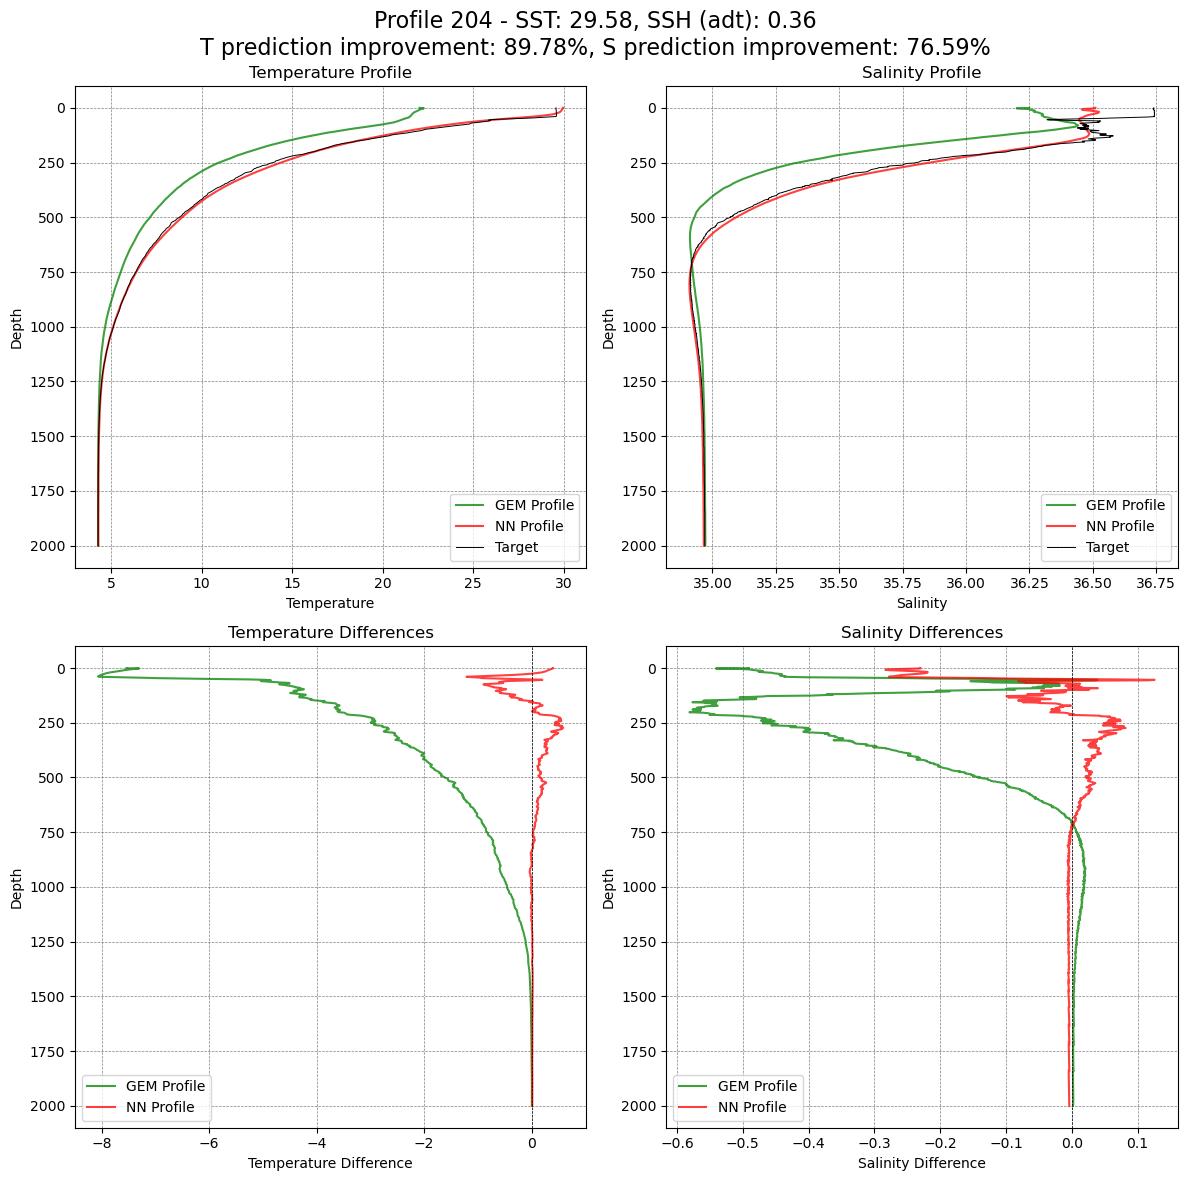

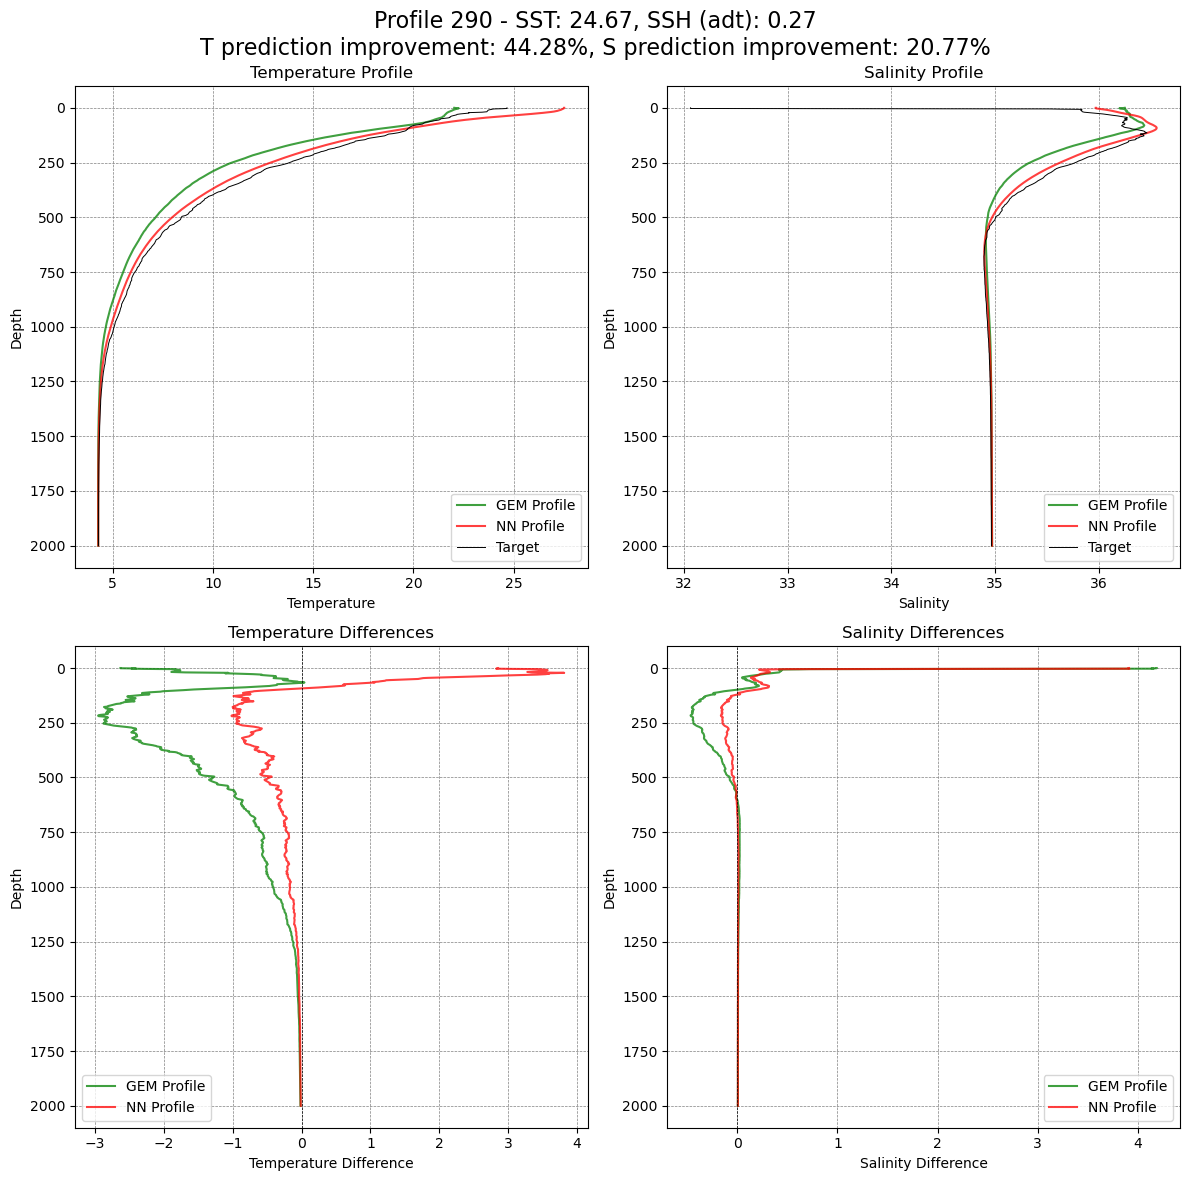

The NN temperature prediction is 81.426% more accurate than the GEM method in the validation set
The NN salinity prediction is 74.117% more accurate than the GEM method in the validation set

Number of profiles: 4049
Parameters used: timecos, timesin, latcos, latsin, loncos, lonsin, sst, sss, ssh
Max depth: 2000
Number of components used: 16 x2
Batch size: 200
Learning rate: 0.001
Dropout probability: 0.35
Train/test/validation split: 0.75/0.125/0.125
Layer configuration: [512, 512, 512]

Winter


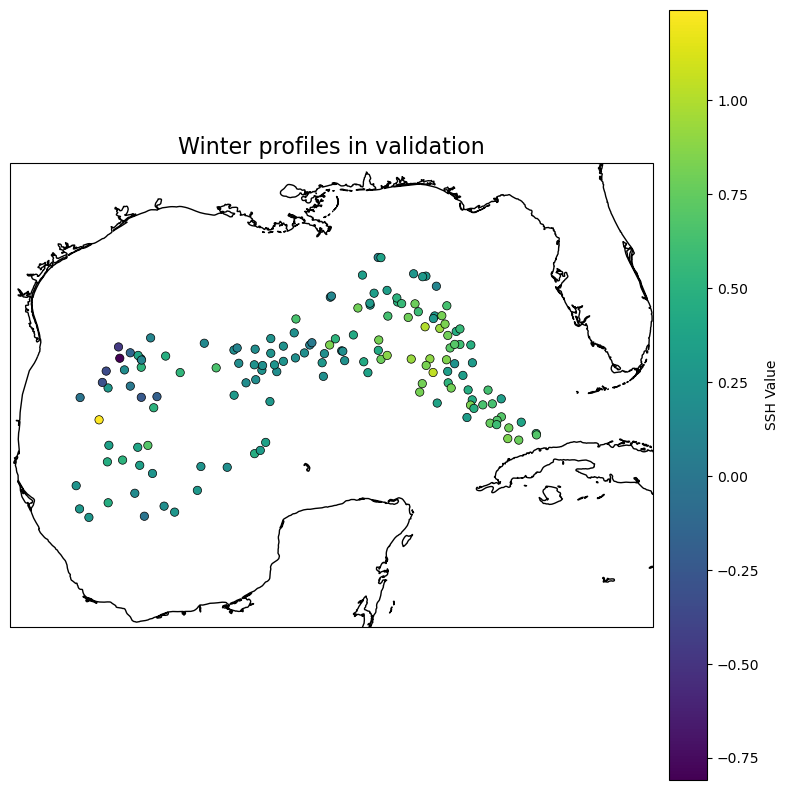

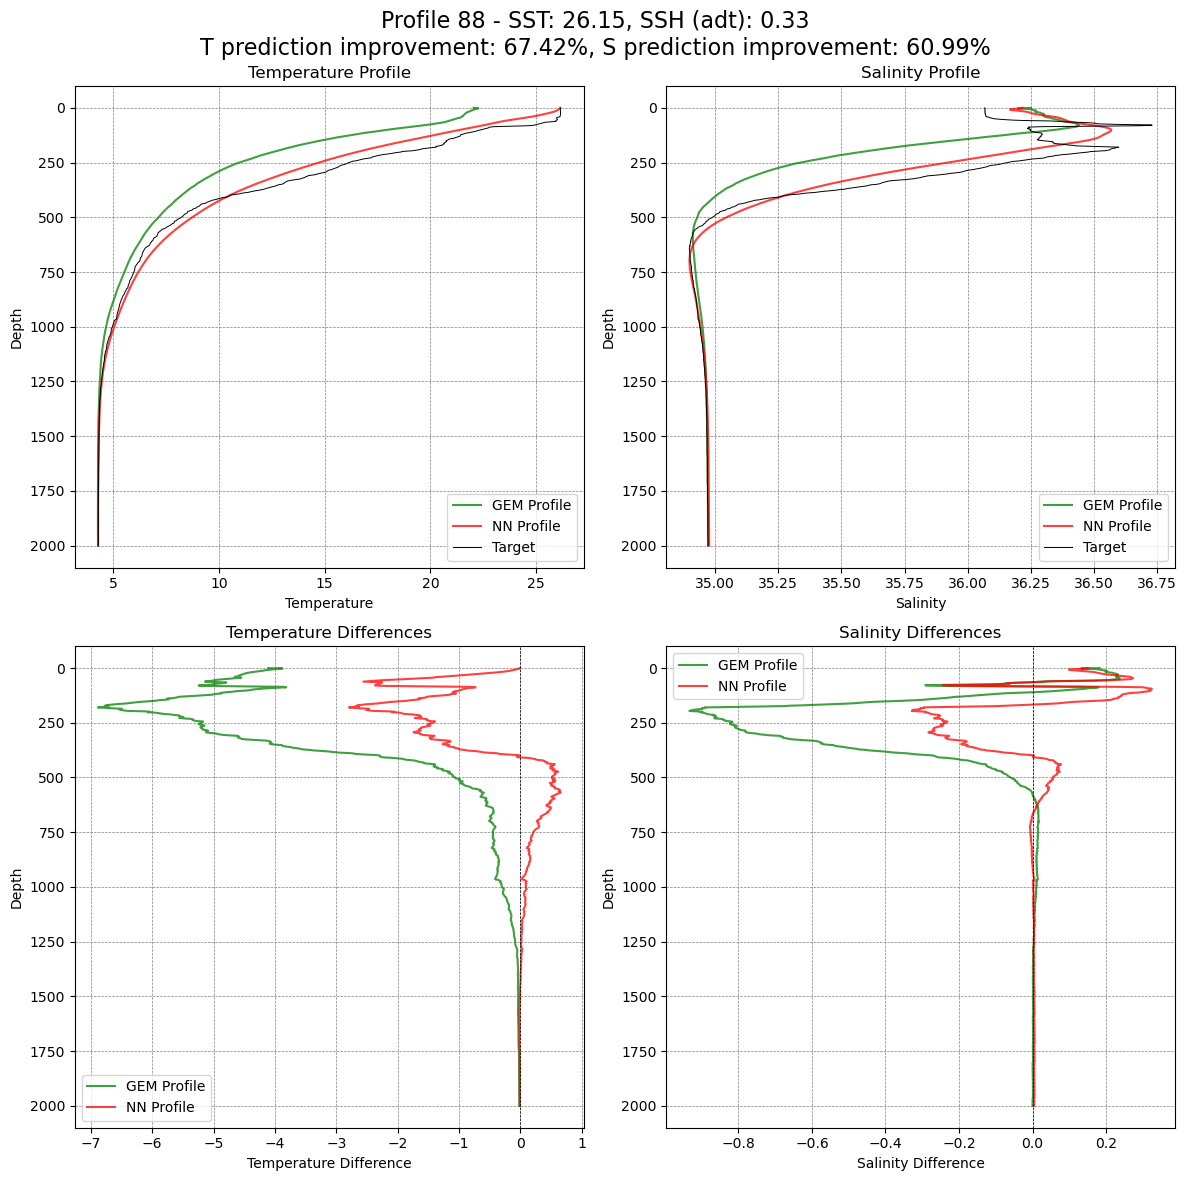

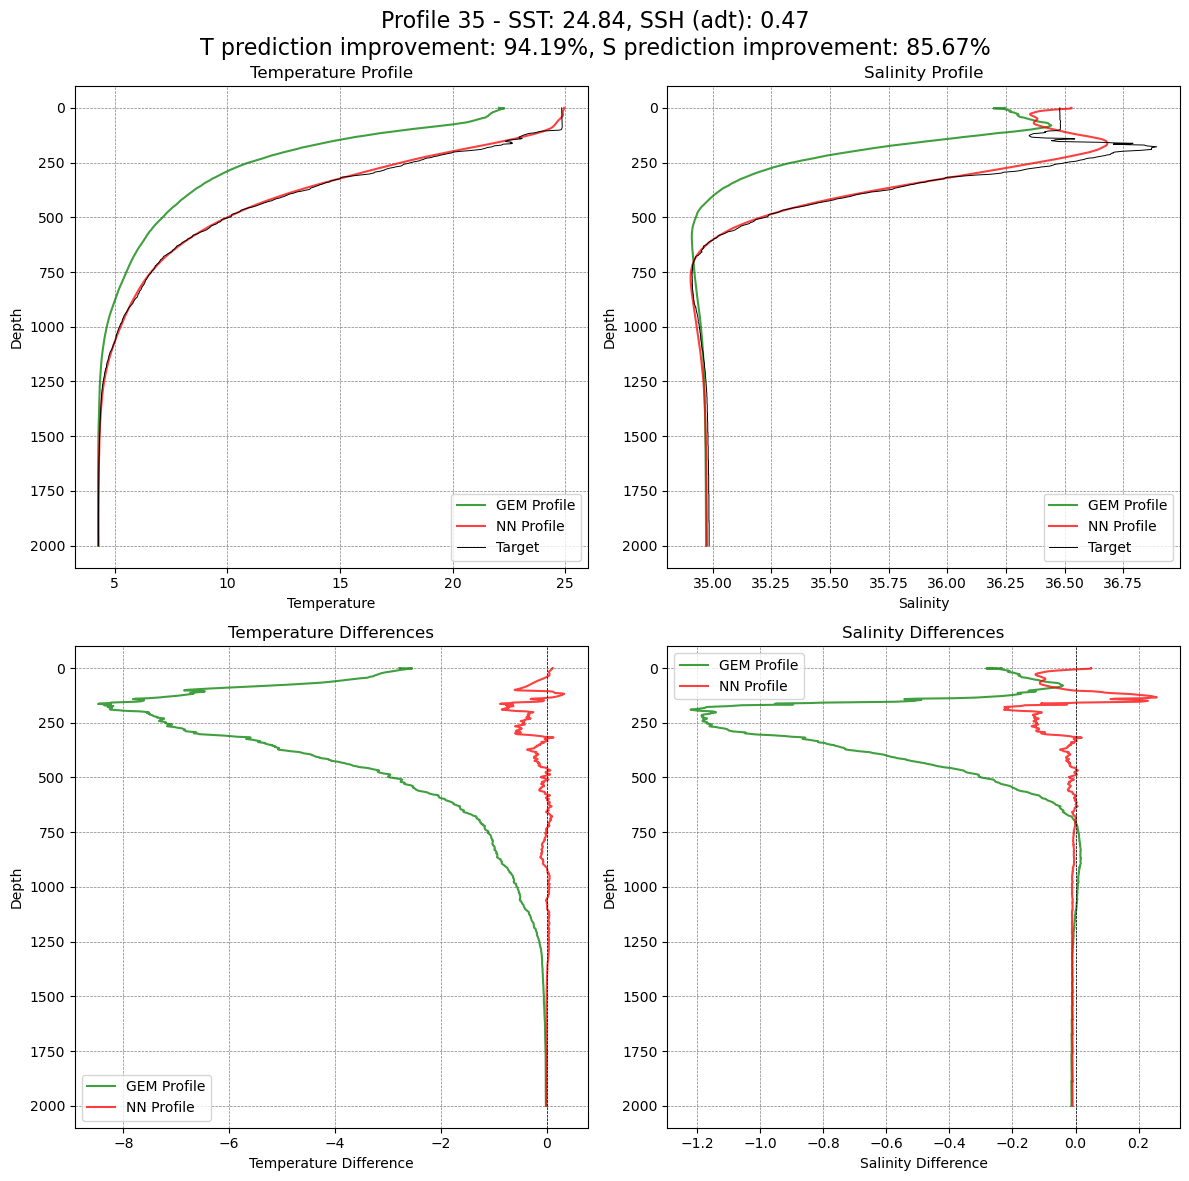

The NN temperature prediction is 81.118% more accurate than the GEM method in the validation set
The NN salinity prediction is 77.377% more accurate than the GEM method in the validation set
Spring


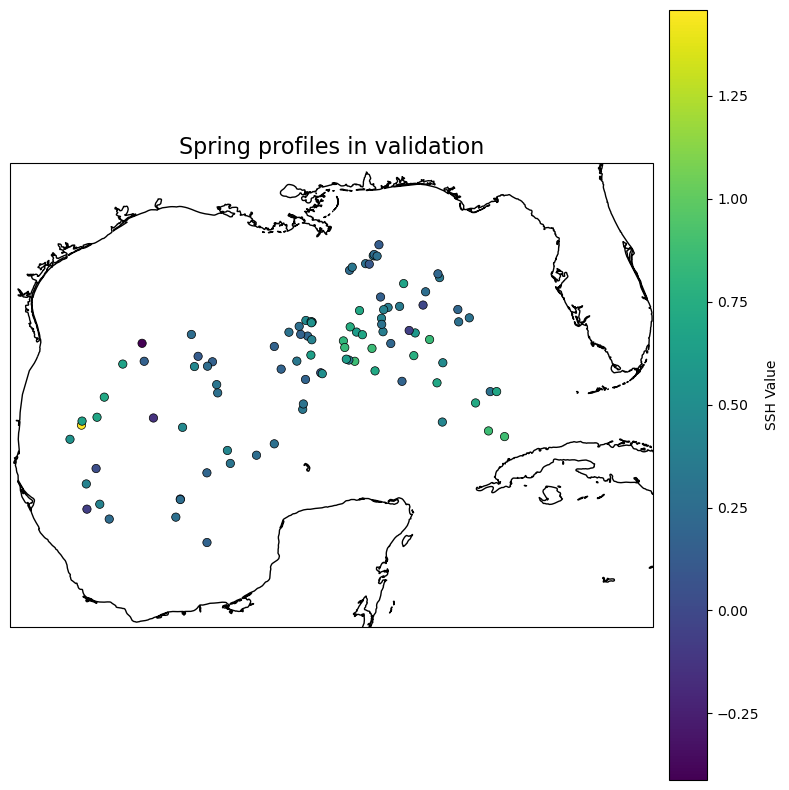

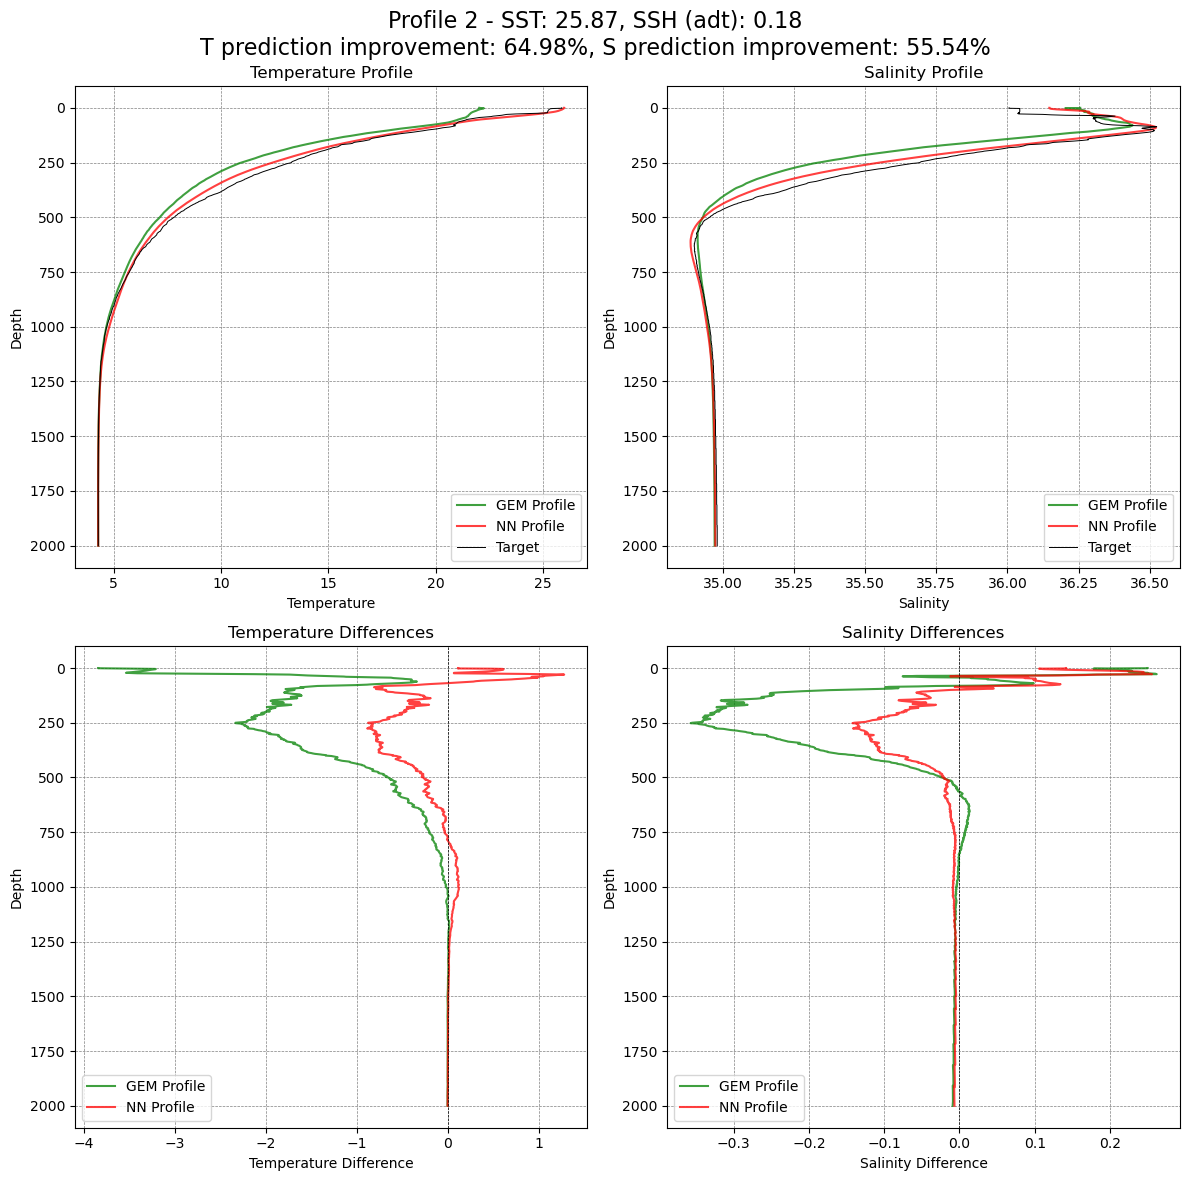

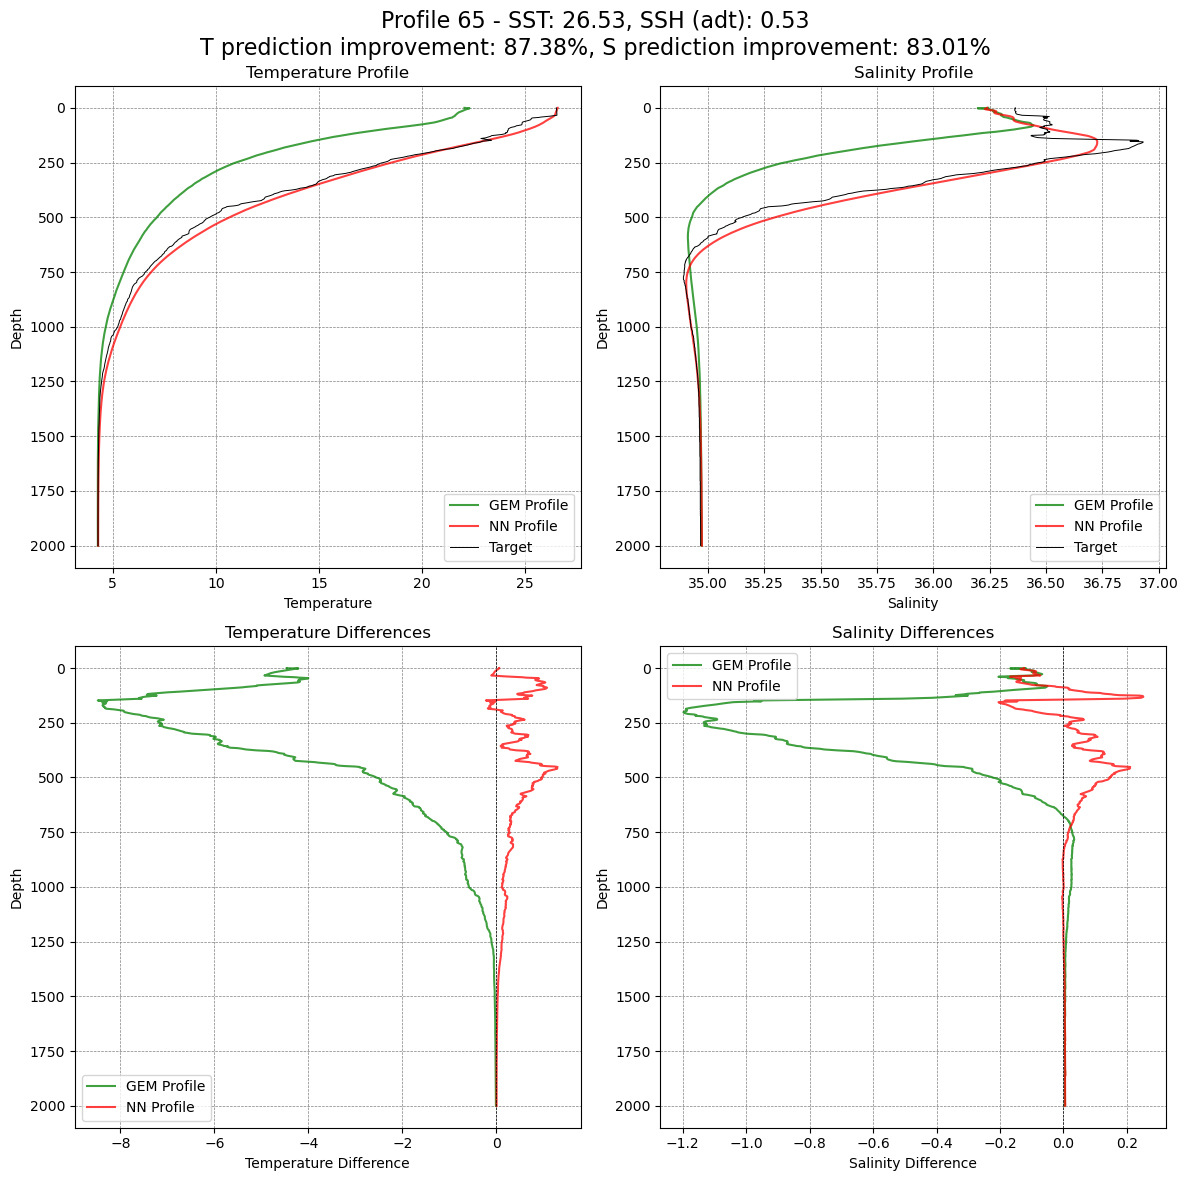

The NN temperature prediction is 80.484% more accurate than the GEM method in the validation set
The NN salinity prediction is 74.231% more accurate than the GEM method in the validation set
Summer


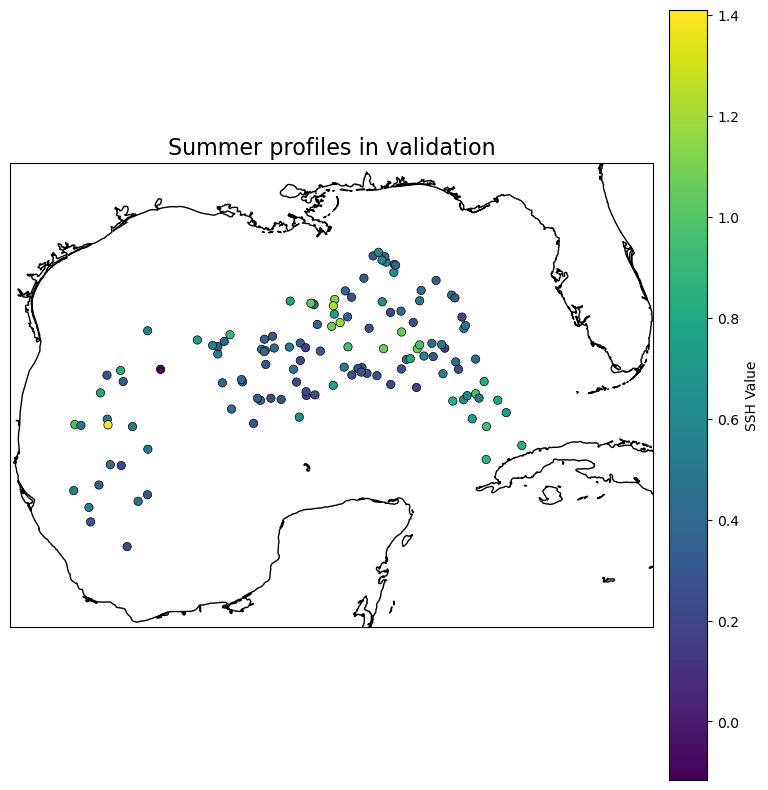

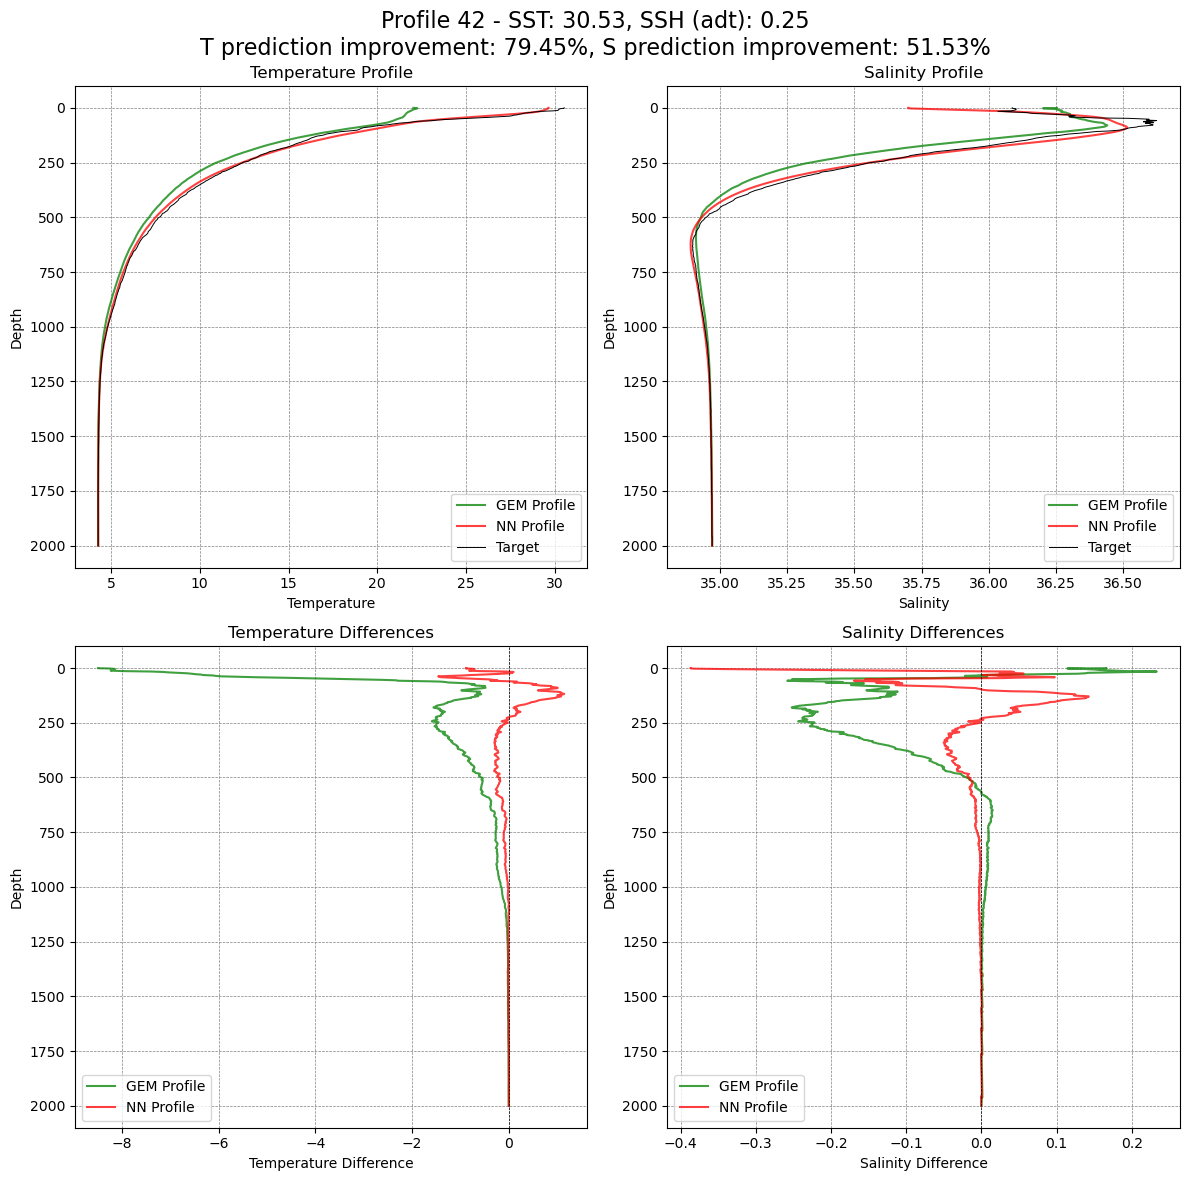

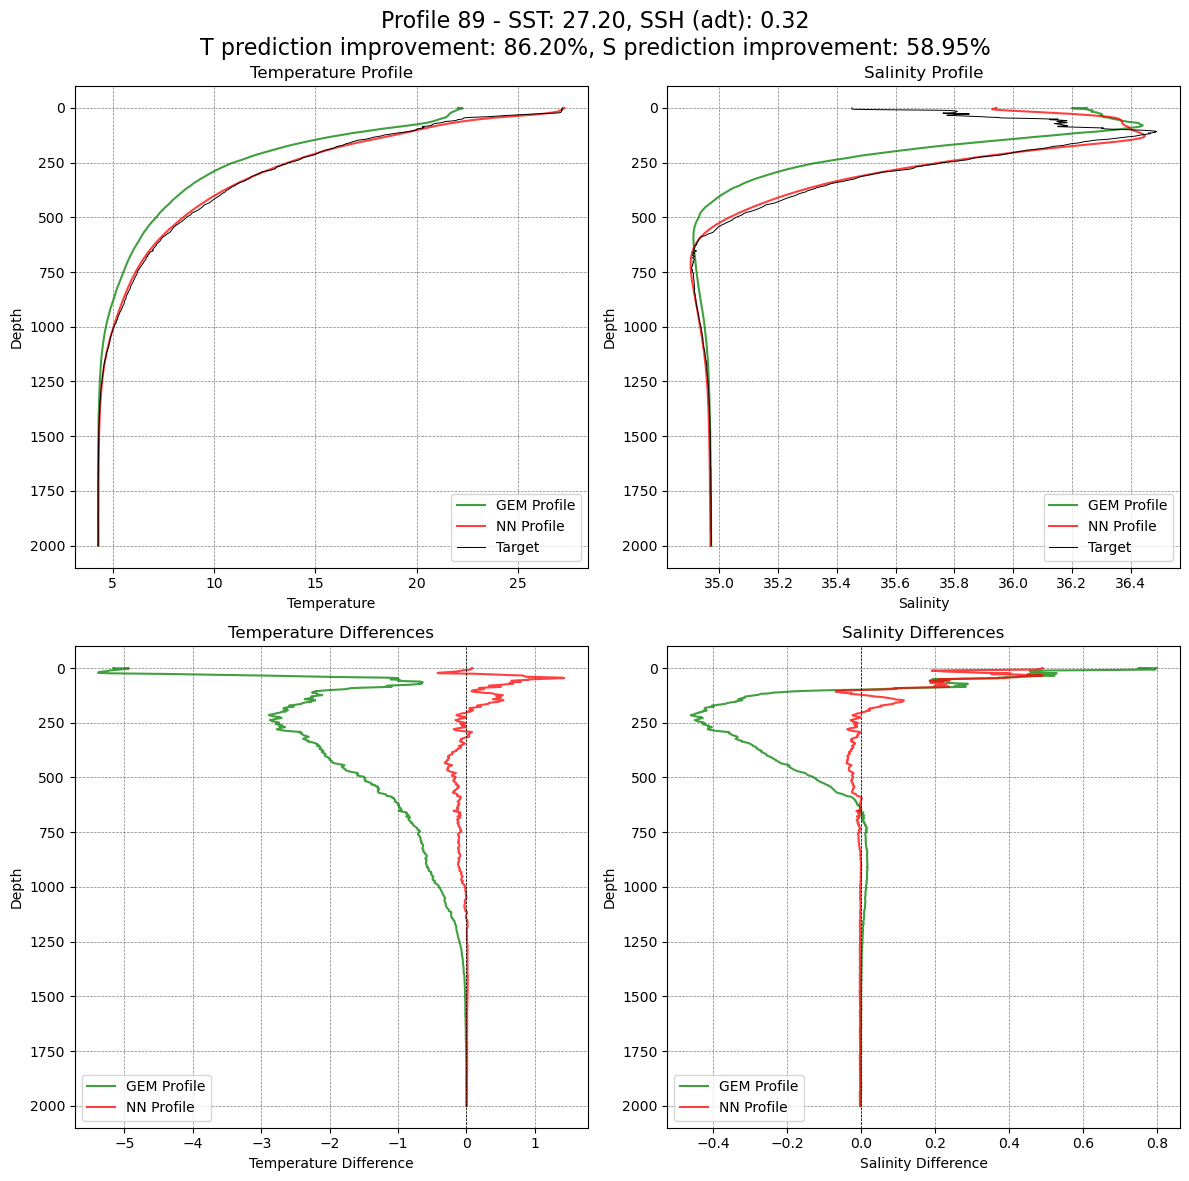

The NN temperature prediction is 84.579% more accurate than the GEM method in the validation set
The NN salinity prediction is 74.687% more accurate than the GEM method in the validation set
Fall


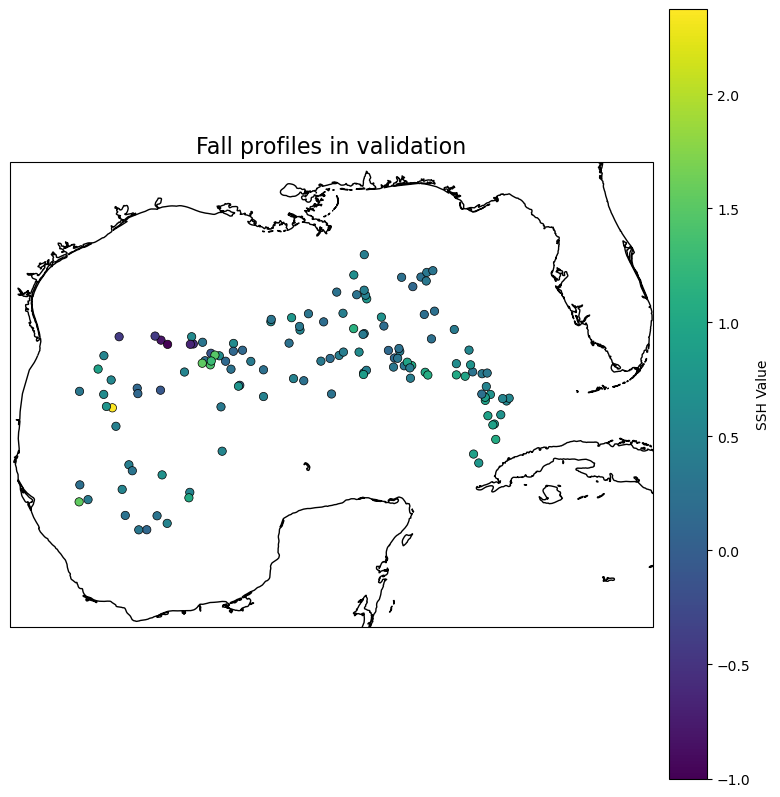

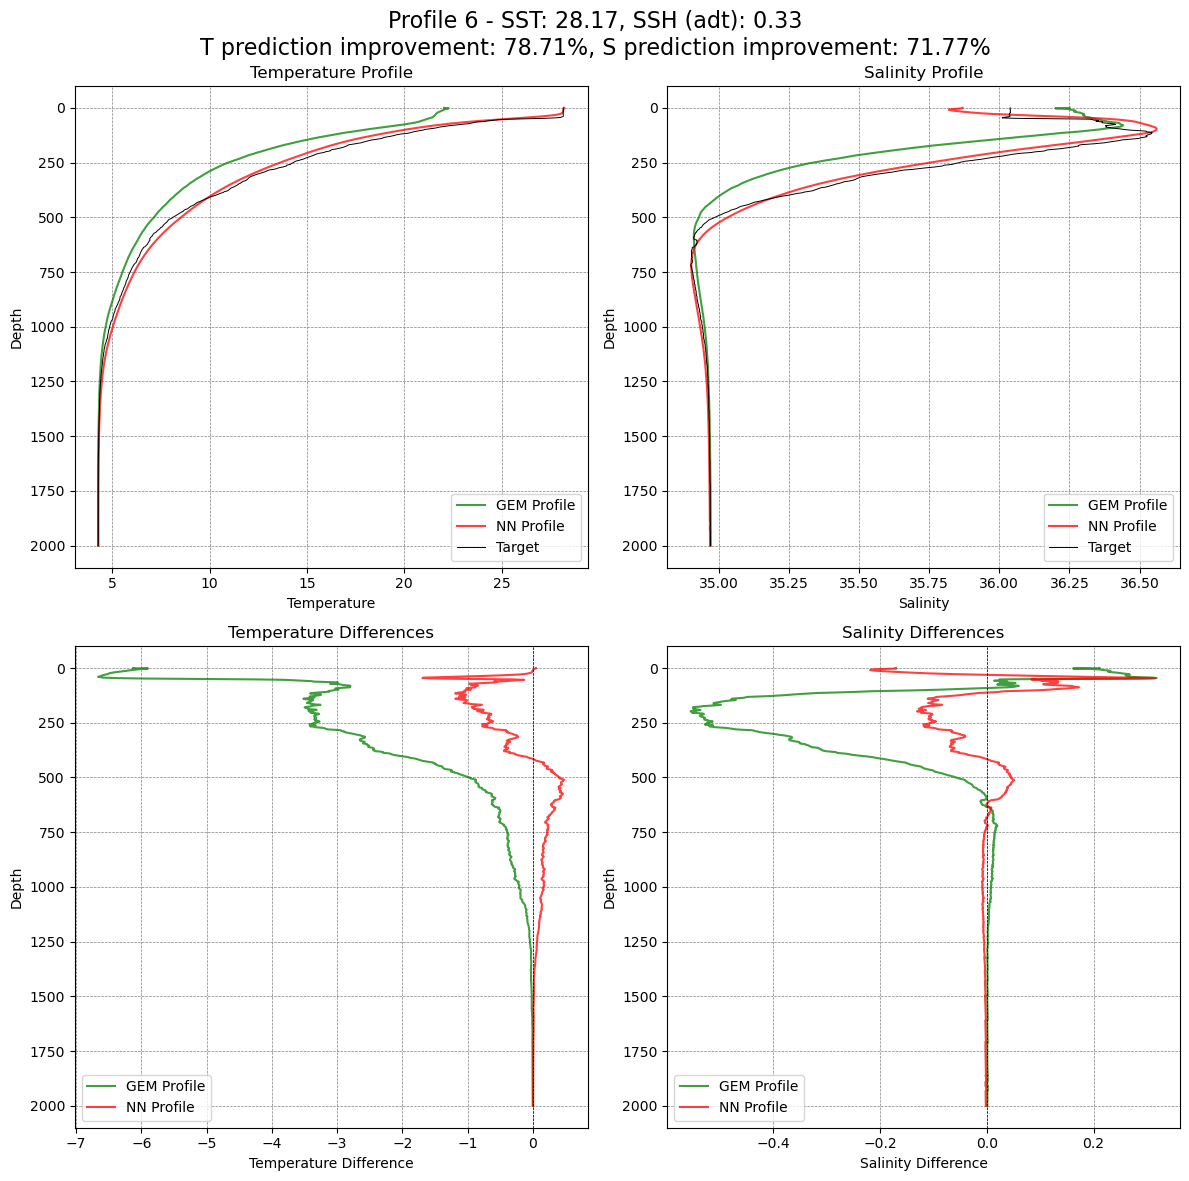

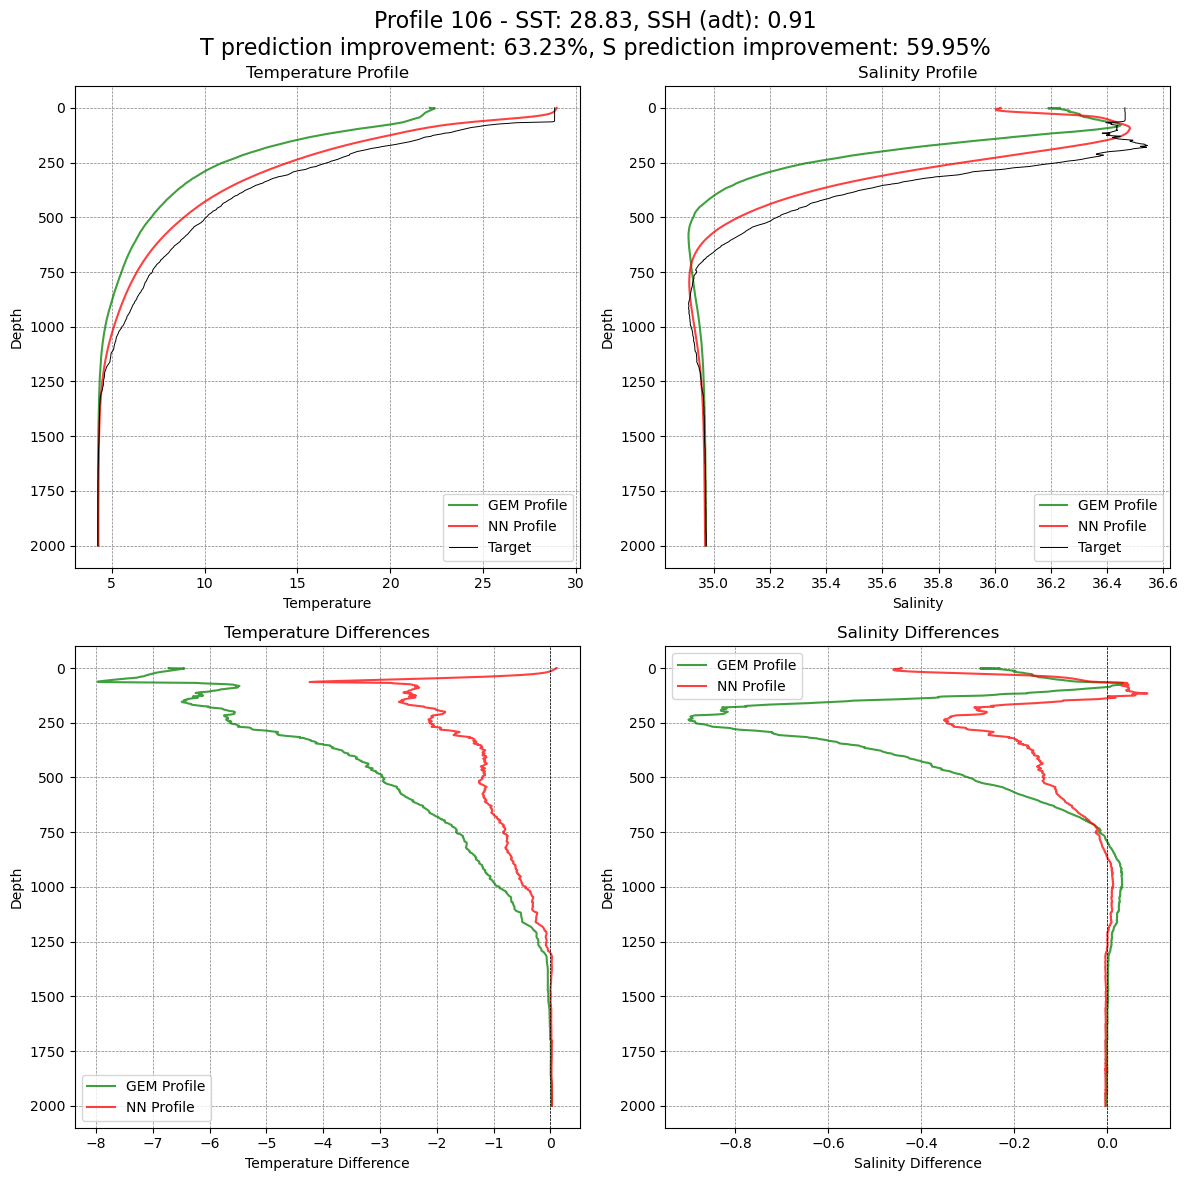

The NN temperature prediction is 79.410% more accurate than the GEM method in the validation set
The NN salinity prediction is 69.942% more accurate than the GEM method in the validation set


NameError: name 'MiniBatchKMeans' is not defined

In [2]:
if __name__ == "__main__":
    # Configurable parameters
    data_path = "/home/jmiranda/SubsurfaceFields/Data/ARGO_GoM_20220920.mat"
    
    # Define the path of the pickle file
    pickle_file = 'config_dataset_full.pkl'

    if os.path.exists(pickle_file):
        # Load data from the pickle file
        with open(pickle_file, 'rb') as file:
            data = pickle.load(file)
            max_depth = data['max_depth']
            epochs = data['epochs']
            patience = data['patience']
            n_components = data['n_components']
            batch_size = data['batch_size']
            learning_rate = data['learning_rate']
            dropout_prob = data['dropout_prob']
            layers_config = data['layers_config']
            input_params = data['input_params']
            train_size = data['train_size']
            val_size = data['val_size']
            test_size = data['test_size']
            full_dataset = data['full_dataset']
    else:
        # Your original initialization code
        max_depth = 2000
        epochs = 10000
        patience = 3000
        n_components = 16
        batch_size = 200
        learning_rate = 0.001
        dropout_prob = 0.35
        layers_config = [512, 512, 512]
        input_params = {
            "timecos": True,
            "timesin": True,
            "latcos": True,
            "latsin": True,
            "loncos": True,
            "lonsin": True,
            "sst": True,  # First value of temperature
            "sss": True,
            "ssh": True
        }
        train_size = 0.75
        val_size = 0.125
        test_size = 0.125

        # Load and split data
        full_dataset = TemperatureSalinityDataset(path=data_path, n_components=n_components, input_params=input_params, max_depth=max_depth)

        # Save data to the pickle file
        with open(pickle_file, 'wb') as file:
            data = {
                'max_depth': max_depth,
                'epochs': epochs,
                'patience': patience,
                'n_components': n_components,
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'dropout_prob': dropout_prob,
                'layers_config': layers_config,
                'input_params': input_params,
                'train_size': train_size,
                'val_size': val_size,
                'test_size': test_size,
                'full_dataset': full_dataset
            }
            pickle.dump(data, file)

    train_dataset, val_dataset, test_dataset = split_dataset(full_dataset, train_size, val_size, test_size)

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Compute the input dimension dynamically
    input_dim = sum(val for val in input_params.values())
    model = PredictionModel(input_dim=input_dim, layers_config=layers_config, output_dim=n_components*2, dropout_prob = dropout_prob)
   
    # Check CUDA availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    weightOffset = 2
    criterion = genWeightedMSELoss(n_components, device, weightOffset)
    # criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # print parameters and dataset size
    true_params = [param for param, value in input_params.items() if value]
    def printParams():   
        print(f"\nNumber of profiles: {len(full_dataset)}")
        print("Parameters used:", ", ".join(true_params))
        print(f"Max depth: {max_depth}")
        print(f"Number of components used: {n_components} x2")
        print(f"Batch size: {batch_size}")
        print(f"Learning rate: {learning_rate}")
        print(f"Dropout probability: {dropout_prob}")
        print(f'Train/test/validation split: {train_size}/{test_size}/{val_size}')
        print(f"Layer configuration: {layers_config}\n")
    
    printParams()

    # Training
    trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, patience)
    
    # Test evaluation
    test_loss = evaluate_model(trained_model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}")

    # Get predictions for the validation dataset
    val_predictions_pcs = get_predictions(trained_model, val_loader, device)
    # Accessing the original dataset for inverse_transform
    val_predictions = val_dataset.dataset.inverse_transform(val_predictions_pcs)

    subset_indices = val_loader.dataset.indices

    # For original profiles
    original_profiles = val_dataset.dataset.get_profiles(subset_indices, pca_approx=False)

    # For PCA approximated profiles
    pca_approx_profiles = val_dataset.dataset.get_profiles(subset_indices, pca_approx=True)

    # num_samples = val_predictions[0].shape[1]
    num_samples = 2    
    # Visualize the results for the validation dataset
    # visualize_results_with_original(original_profiles, pca_approx_profiles, val_predictions, max_depth = max_depth, num_samples=num_samples)

    torch.save(trained_model, "model.pth")
    
    with open("pca_temp.pkl", "wb") as f:
        pickle.dump(full_dataset.pca_temp, f)

    with open("pca_sal.pkl", "wb") as f:
        pickle.dump(full_dataset.pca_sal, f)
        
    
    sst_inputs, ssh_inputs = val_dataset.dataset.get_inputs(subset_indices)
    
    gem_temp, gem_sal = val_dataset.dataset.get_gem_profiles(subset_indices)
    
    lat_val, lon_val, dates_val = val_dataset.dataset.get_lat_lon_date(subset_indices)

    # Visualize the results for the validation dataset versus GEM
    # visualize_results_with_gem(original_profiles, gem_temp, gem_sal, val_predictions, sst_inputs, ssh_inputs, max_depth = max_depth, num_samples=num_samples)
    # seasonal_plots(lat_val, lon_val, dates_val, original_profiles, gem_temp, gem_sal, val_predictions, sst_inputs, ssh_inputs, max_depth, num_samples)
    visualize_combined_results(original_profiles, gem_temp, gem_sal, val_predictions, sst_inputs, ssh_inputs, max_depth = max_depth, num_samples=num_samples)
    
    printParams()
    
    # Plots and comparisons with GEM (uncomment to use)
   
    seasonal_plots(lat_val, lon_val, dates_val, original_profiles, gem_temp, gem_sal, val_predictions, sst_inputs, ssh_inputs, max_depth, num_samples)
    
    #
    #
    # RMSE Calculations and Accuracy Gain
    gem_temp_errors = (gem_temp.T - original_profiles[:, 0, :]) ** 2
    gem_sal_errors = (gem_sal.T - original_profiles[:, 1, :]) ** 2

    nn_temp_errors = (val_predictions[0][:, :] - original_profiles[:, 0, :]) ** 2
    nn_sal_errors = (val_predictions[1][:, :] - original_profiles[:, 1, :]) ** 2

    gem_temp_rmse = np.sqrt(np.mean(gem_temp_errors, axis = 0))
    gem_sal_rmse = np.sqrt(np.mean(gem_sal_errors, axis = 0))

    nn_temp_rmse = np.sqrt(np.mean(nn_temp_errors, axis = 0))
    nn_sal_rmse = np.sqrt(np.mean(nn_sal_errors, axis = 0))
    
    accuracy_gain_temp = 100*(gem_temp_rmse-nn_temp_rmse)/gem_temp_rmse
    accuracy_gain_sal = 100*(gem_sal_rmse-nn_sal_rmse)/gem_sal_rmse
    
    n_clusters=5
    
    variable_name = "Temperature"
    
    kmeans = MiniBatchKMeans(n_clusters=n_clusters,
                          random_state=42,
                          batch_size=64,
                          n_init="auto").fit_predict(accuracy_gain_temp.reshape(-1,1))
    
    for cluster in np.arange(0,n_clusters):
        idx = kmeans == cluster
        num_samples = np.sum(idx)
        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))
        ax.set_global()
        ax.coastlines()
        # Setting plot limits to the Gulf of Mexico region
        ax.set_extent([-98, -80, 18, 31])
        scatter = ax.scatter(lon_val[idx], lat_val[idx], c=ssh_inputs[idx], cmap='viridis', edgecolors='k', linewidth=0.5, transform=ccrs.PlateCarree())
        cbar = plt.colorbar(scatter, ax=ax, orientation="vertical", pad=0.02, shrink=1)
        cbar.set_label("SSH Value")

        ax.set_title(f"{variable_name} Cluster {cluster} profiles in validation \n {variable_name} accuracy gain ranges from {min_rmse:.1f}% to {max_rmse:.1f}%", fontsize=16)
        plt.show()
        
        min_rmse = np.min(accuracy_gain_temp[idx])
        max_rmse = np.max(accuracy_gain_temp[idx])
        
        
    variable_name = "Salinity"
    
    kmeans = MiniBatchKMeans(n_clusters=n_clusters,
                          random_state=42,
                          batch_size=64,
                          n_init="auto").fit_predict(accuracy_gain_sal.reshape(-1,1))
    
    for cluster in np.arange(0,n_clusters):
        idx = kmeans == cluster
        num_samples = np.sum(idx)
        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))
        ax.set_global()
        ax.coastlines()
        # Setting plot limits to the Gulf of Mexico region
        ax.set_extent([-98, -80, 18, 31])
        scatter = ax.scatter(lon_val[idx], lat_val[idx], c=ssh_inputs[idx], cmap='viridis', edgecolors='k', linewidth=0.5, transform=ccrs.PlateCarree())
        cbar = plt.colorbar(scatter, ax=ax, orientation="vertical", pad=0.02, shrink=1)
        cbar.set_label("SSH Value")

        ax.set_title(f"{variable_name} Cluster {cluster} profiles in validation \n {variable_name} accuracy gain ranges from {min_rmse:.1f}% to {max_rmse:.1f}%", fontsize=16)
        plt.show()
        
        min_rmse = np.min(accuracy_gain_sal[idx])
        max_rmse = np.max(accuracy_gain_sal[idx])
        

    
    cluster_plots(lat_val, lon_val, dates_val, original_profiles, gem_temp, gem_sal, val_predictions, sst_inputs, ssh_inputs, max_depth, kmeans)
    # """
        
    #TODO: predict profiles for Paula

    # class PredictionDataset(torch.utils.data.Dataset):
    #     """
    #     Custom dataset for making predictions using the trained model.
        
    #     Attributes:
    #     - time_data: Array of time data.
    #     - ssh_data: Sea Surface Height data.
    #     - sst_data: Sea Surface Temperature data.
    #     """
    #     def __init__(self, input_params=None):
    #         """
    #         Args:
    #         - all_time_data (array): Array of time data.
    #         - ssh_data (array): Array of Sea Surface Height data.
    #         - sst_data (array): Array of Sea Surface Temperature data.
    #         """
    #         # Specify the filename to load
    #         filename = '/home/jmiranda/SubsurfaceFields/GEM_SubsurfaceFields/paula_profiles.pkl'

    #         # Initialize variables so you can use them after loading the data
    #         all_lat_data, all_lon_data, all_time_data, sst_data, aviso_data = None, None, None, None, None

    #         # Open the file in read mode and load the dictionary
    #         with open(filename, 'rb') as file:
    #             loaded_data = pickle.load(file)
    #             all_lat_data = loaded_data['lat']
    #             all_lon_data = loaded_data['lon']
    #             all_time_data = loaded_data['time']
    #             sst_data = loaded_data['sst']
    #             aviso_data = loaded_data['ssh']
    #         self.TIME = all_time_data
    #         self.SSH = aviso_data
    #         self.SST = sst_data
    #         self.LAT = all_lat_data
    #         self.LON = all_lon_data
            
    #         # Define which parameters to include
    #         if input_params is None:
    #             input_params = {
    #                 "timecos": False,
    #                 "timesin": False,
    #                 "lat": False,
    #                 "lon": False,
    #                 "sst": True,  # First value of temperature
    #                 "sss": True,
    #                 "ssh": True
    #             }

    #         self.input_params = input_params

    #     def __len__(self):
    #         """
    #         Returns number of samples in the dataset.
    #         """
    #         return len(self.TIME)

    #     def __getitem__(self, idx):
    #         """
    #         Args:
    #         - idx (int): Index

    #         Returns:
    #         - tuple: Tuple (input_params, dummy_target), where dummy_target is just a placeholder.
    #         """
    #         inputs = []
            
    #         if self.input_params["timecos"]:
    #             inputs.append(np.cos(2*np.pi*(self.TIME[idx]%365)/365)) 
                
    #         if self.input_params["timesin"]:
    #             inputs.append(np.sin(2*np.pi*(self.TIME[idx]%365)/365))  
                
    #         if self.input_params["ssh"]:
    #             inputs.append(self.SSH[idx])
            
    #         if self.input_params["sst"]:
    #             inputs.append(self.SST[idx])

    #         inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
            
    #         # For predictions, the target can be a dummy variable as it's not used during predictions
    #         dummy_target = torch.tensor([0])  # not used during predictions
            
    #         return inputs_tensor, dummy_target
        
    #     def get_lat_lon_date(self, idx):
    #         lat = self.LAT[idx]
    #         lon = self.LON[idx]
    #         date = self.TIME[idx]
    #         return lat, lon, date
        
    # paula_dataset = PredictionDataset(input_params=input_params)
    # paula_loader = DataLoader(paula_dataset, batch_size=batch_size, shuffle=False)
    # printParams()
    # # Get predictions for the validation dataset
    # paula_predictions_pcs = get_predictions(trained_model, paula_loader, device)
    # # Accessing the original dataset for inverse_transform
    # paula_predictions = val_dataset.dataset.inverse_transform(paula_predictions_pcs)

    # # Separate temperature and salinity predictions
    # temperature_predictions = paula_predictions[0]
    # salinity_predictions = paula_predictions[1]
    
    # # Retrieve lat, lon and date
    # lat, lon, date = paula_dataset.get_lat_lon_date(np.arange(len(paula_dataset)))

    # # Create a dictionary containing the data you want to save
    # data_to_save = {
    #     'temperature_predictions': temperature_predictions,
    #     'salinity_predictions': salinity_predictions,
    #     'lat': lat,
    #     'lon': lon,
    #     'date': date,
    #     'model_params' : input_params
    # }

    # # Specify the filename to save to
    # if input_params["sst"]:
    #     filename = '/home/jmiranda/SubsurfaceFields/GEM_SubsurfaceFields/predictions_sst_ssh_time.pkl'
    # else:
    #     filename = '/home/jmiranda/SubsurfaceFields/GEM_SubsurfaceFields/predictions_ssh_time.pkl'

    # # Open the file in write mode and save the dictionary
    # with open(filename, 'wb') as file:
    #     pickle.dump(data_to_save, file)

    # print(f"Predictions have been saved to {filename}")